In [23]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

# S2 - Clustering

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/tvd/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
data_path = "../data/txt/"
DECADE = "1960"

files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]
texts = [open(data_path + f, "r", encoding= "utf-8").read() for f in files]

In [5]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [6]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    # min max peut etre changé pour le travail, min est assez élévé...
    lowercase=True)

In [7]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [8]:
tfidf_vectors.shape

(1000, 2997)

In [9]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

rossel        0.429822
ecrire        0.290745
agence        0.287284
bilingue      0.195608
importante    0.172357
                ...   
er            0.000000
erreurs       0.000000
esp           0.000000
espagne       0.000000
♦             0.000000
Length: 2997, dtype: float64

In [10]:
print(cosine([1, 2, 3], [1, 2, 3]))
print(cosine([1, 2, 3], [1, 2, 2]))
print(cosine([1, 2, 3], [2, 2, 2]))

0
0.02004211298777725
0.07417990022744858


In [11]:
tfidf_array = tfidf_vectors.toarray()

In [12]:
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
tfidf_array[1]

array([0.        , 0.        , 0.01046606, ..., 0.01088858, 0.01243841,
       0.        ])

In [14]:
cosine(tfidf_array[0], tfidf_array[1])


0.9628815101868748

In [15]:
N_CLUSTERS = 3
# 3 semblent le meilleur choix car le centre est  centré si on multiplie, il divise la section haute à droite, sans  réellement changer le reste.

In [16]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [17]:
clusters = km_model.fit_predict(tfidf_vectors)

In [18]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [19]:
pprint(dict(clustering))

{0: ['KB_JB838_1960-01-10_01-00018.txt',
     'KB_JB838_1960-02-03_01-00019.txt',
     'KB_JB838_1960-02-13_01-00020.txt',
     'KB_JB838_1960-03-11_01-00020.txt',
     'KB_JB838_1960-03-25_01-00020.txt',
     'KB_JB838_1960-03-29_01-00018.txt',
     'KB_JB838_1960-04-01_01-00020.txt',
     'KB_JB838_1960-04-02_01-00017.txt',
     'KB_JB838_1960-04-30_01-00016.txt',
     'KB_JB838_1960-07-06_01-00020.txt',
     'KB_JB838_1960-08-04_01-00018.txt',
     'KB_JB838_1960-08-13_01-00016.txt',
     'KB_JB838_1960-08-28_01-00019.txt',
     'KB_JB838_1960-09-18_01-00020.txt',
     'KB_JB838_1960-10-28_01-00020.txt',
     'KB_JB838_1960-11-04_01-00019.txt',
     'KB_JB838_1960-11-12_01-00017.txt',
     'KB_JB838_1960-11-13_01-00019.txt',
     'KB_JB838_1960-11-25_01-00020.txt',
     'KB_JB838_1960-12-10_01-00019.txt',
     'KB_JB838_1960-12-21_01-00017.txt',
     'KB_JB838_1960-12-23_01-00019.txt',
     'KB_JB838_1961-02-02_01-00019.txt',
     'KB_JB838_1961-02-11_01-00017.txt',
     'KB_JB838_1

In [20]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [21]:
reduced_vectors[:10]

array([[ 0.49940241, -0.43947915],
       [-0.22882536,  0.00137802],
       [-0.27935515, -0.01591002],
       [ 0.28620178,  0.51679289],
       [ 0.30678362,  0.51829431],
       [-0.28971534, -0.09053845],
       [-0.04734942,  0.0405362 ],
       [-0.06057915,  0.11984376],
       [-0.2234518 , -0.05226794],
       [-0.12138459,  0.0747042 ]])

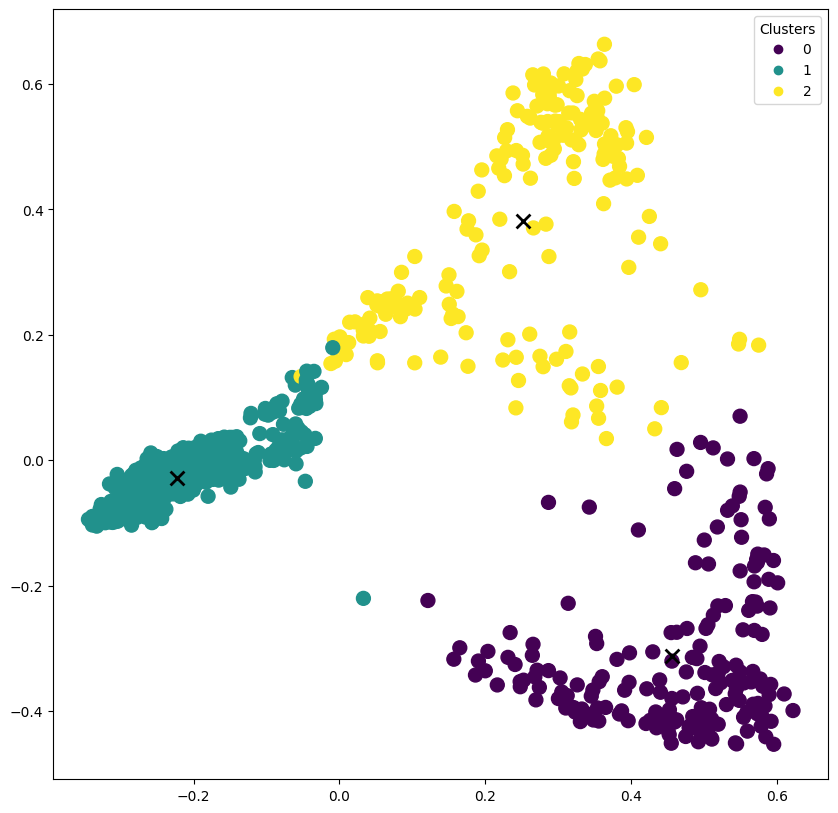

In [22]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')
# les centres sont indiqués par les croix

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# S4 - Word Embeddings

In [24]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [25]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

In [26]:
bigram_phrases = Phrases(sentences)

In [27]:
type(bigram_phrases.vocab)

dict

In [28]:
len(bigram_phrases.vocab.keys())

15850647

In [29]:
key_ = list(bigram_phrases.vocab.keys())[144]
print(key_)

1q


In [30]:
bigram_phrases.vocab[key_]

488

In [31]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [32]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [33]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [34]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [35]:
print(corpus[:100])

[['mi', 'imnri', 'r', 'i', '<<', 'i', 'i', 'hmu', "'", 'i', '/', 'tx', "-'", 'l', ':', 'marche', 'tenu', 'hors', 'villa', ',', 'la', '9', '.'], ['--', 'u', 'a', 'ete', 'vaain', 'si', 'teicj', '>>', 'm', 'races_indigenes', 'de', 'fr', '.'], ['31', '<)', 'a', '5s', "'", 'k', '131', 'de', '.'], ['rasa', 'iichakdui', "'", 'te', ',', 'do', '(', 'r', '.', '3s0', 'h', '710', '.', 'taureaux', 'iallsenas', ',>', 'ia', 'u', '\\', '--', 'a', '--', ';', '0ii', '.'], ['hollandais', ',', 'dufr', '.'], ['0', '.'], ['--', 'a', '9', '.--', 'la', 'idto', '-', 'vachei', 'laitieres', ':', 'bn', 'vante', '1q', '.'], ['vendues', '3', '\\', 'au', 'prix', 'la', '410', 'a', '*', '<<', 'i', 'h', '\\;', 'genisses', ',', 'kl', '.'], ["'.", '9', '.'], ['i', 'l', '.', '2', 'i', '.', 'id', '.'], ['da', '370', 'i', '6lutr', '.'], ['marche', 'a', '<', 'u', 'porcs', '.'], ['--', 'categorie', 'de', 'lt', 'ilashtya', ':', "'", '237', 'on', 'vente', ';', 'vendus', '1', 'm', '.', 'do', "'", '2', 'i', '.--', 'a', ';:,', 'l'

In [36]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: user 15min 28s, sys: 3.77 s, total: 15min 31s
Wall time: 5min 6s


In [37]:
outfile = f"../data/newspapers.model"
model.save(outfile)

In [38]:
model = Word2Vec.load("../data/newspapers.model")

In [39]:
model.wv["ministre"]

array([ 0.5783947 , -0.7647437 ,  0.06125074, -1.3594831 , -2.8163593 ,
        2.2189734 , -1.9741641 ,  0.514594  , -1.1584314 , -3.0047219 ,
       -1.9478369 ,  0.09997236, -3.67784   , -1.1153616 ,  7.0412235 ,
        8.681069  , -2.6714485 , -0.8913672 ,  9.634043  , -8.775073  ,
       -2.132759  , -4.1380286 ,  3.5546873 , -5.8924236 ,  1.8173424 ,
        3.586534  , -7.585331  , -2.1418471 ,  2.470336  , -7.4911733 ,
       -7.0552683 , -6.462807  ], dtype=float32)

In [40]:
model.wv.similarity("ministre", "roi")

0.6782441

In [99]:
model.wv.most_similar("etterbeek", topn=10)

[('evere', 0.9463777542114258),
 ('ixelles', 0.9199624061584473),
 ('ucele', 0.915294349193573),
 ('etterbcek', 0.9147604703903198),
 ('auderghem', 0.9073496460914612),
 ('ixclles', 0.9054746031761169),
 ('uecle', 0.9029334187507629),
 ('ixolles', 0.8960521817207336),
 ('elterbeek', 0.8949348330497742),
 ('uocle', 0.8928379416465759)]

In [45]:
print(model.wv.most_similar(positive=['paris', 'londres'], negative=[ 'france']))

[('new_york', 0.8031440377235413), ('berlin', 0.7786092758178711), ('lundi_prochain', 0.7655465006828308), ('berne', 0.7612034678459167), ('helsinki', 0.7551062107086182), ('alger', 0.7495841383934021), ('amsterdam', 0.7423217296600342), ('budapest', 0.7394174337387085), ('stockholm', 0.7361766695976257), ('tokio', 0.7343018651008606)]


In [51]:
model.wv.most_similar(positive=['feminisme'])

[('scandale', 0.9146893620491028),
 ('christianisme', 0.9073907732963562),
 ('parlementarisme', 0.8951576352119446),
 ('spiritisme', 0.887296199798584),
 ('monde_civilise', 0.884182870388031),
 ('surrealisme', 0.8835927248001099),
 ('romantisme', 0.8822988867759705),
 ('monda', 0.8814530372619629),
 ('troisieme_acte', 0.8785176873207092),
 ('naturalisme', 0.8767390847206116)]

In [78]:
model.wv.most_similar(positive=['suffrage'])

[('proletariat', 0.9103590846061707),
 ('suffrage_universel', 0.8813332915306091),
 ('service_personnel', 0.8709632754325867),
 ('corps_medical', 0.8641693592071533),
 ('front_populaire', 0.8611005544662476),
 ('regime_actuel', 0.8599429130554199),
 ('pouvoir_executif', 0.8587902784347534),
 ('nouveau_regime', 0.8585869669914246),
 ('peuple_americain', 0.8574554920196533),
 ('peuple_belge', 0.8534605503082275)]

In [79]:
model.wv.most_similar(positive=['suffragette'])

[('legere_indisposition', 0.8527250289916992),
 ('interjection', 0.8507227301597595),
 ('loque_humaine', 0.8461951017379761),
 ('vislto', 0.8396833539009094),
 ('scene_penible', 0.8388402462005615),
 ('tentative_criminelle', 0.8340950608253479),
 ('inadvertance', 0.8266990780830383),
 ('rivale_directe', 0.8260394930839539),
 ('extreme_douceur', 0.8249185681343079),
 ('commotion_nerveuse', 0.822457492351532)]

In [83]:
model.wv.most_similar(positive=['suffragette', 'election'])

[('assemblee_nationale', 0.8412980437278748),
 ('mort_violente', 0.8374667763710022),
 ('election_partielle', 0.8356995582580566),
 ('encyclique', 0.833297073841095),
 ('assemblee_constituante', 0.8141555786132812),
 ('interpellation', 0.8076476454734802),
 ('algarade', 0.8076061010360718),
 ('assemblee_pleniere', 0.805510401725769),
 ('operalion', 0.8025354146957397),
 ('assemblee_wallonne', 0.8011733889579773)]